In [2]:
!pip install opencv-python

In [1]:
import tensorflow as tf
import os

/Users/anikait/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')


[]

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'Data/Images' 


In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']


In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory(directory = data_dir ,label_mode = 'categorical',color_mode = "grayscale",image_size =(63, 1197),batch_size=60 )

Found 634 files belonging to 4 classes.


In [10]:
iterator = data.as_numpy_iterator()


In [11]:
batch = iterator.next()

/Users/anikait/opt/anaconda3/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


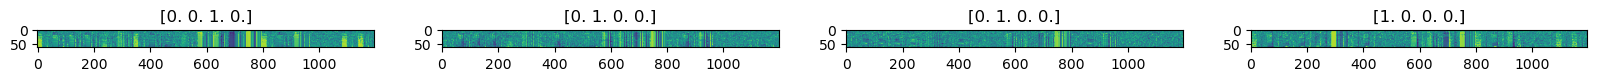

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [13]:
data = data.map(lambda x,y: (x/255, y))


In [14]:
data.as_numpy_iterator().next()

(array([[[[0.5372549 ],
          [0.7254902 ],
          [0.47843137],
          ...,
          [0.8627451 ],
          [0.03529412],
          [0.23921569]],
 
         [[0.9647059 ],
          [0.6117647 ],
          [0.01176471],
          ...,
          [0.16862746],
          [0.6156863 ],
          [0.1882353 ]],
 
         [[0.3254902 ],
          [0.56078434],
          [0.18431373],
          ...,
          [0.9019608 ],
          [0.85490197],
          [0.32156864]],
 
         ...,
 
         [[0.7882353 ],
          [0.85882354],
          [0.07450981],
          ...,
          [0.38039216],
          [0.85490197],
          [0.6627451 ]],
 
         [[0.73333335],
          [0.83137256],
          [0.        ],
          ...,
          [0.13333334],
          [0.13333334],
          [0.9490196 ]],
 
         [[0.8       ],
          [0.14509805],
          [0.6862745 ],
          ...,
          [0.2509804 ],
          [0.2509804 ],
          [0.4117647 ]]],
 
 
        [

In [15]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [16]:
train_size


7

In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [18]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 63, 1197, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [20]:
model = Sequential()

In [21]:
model.add(Conv2D(16, (3,3), 1, activation='LeakyReLU', input_shape=(63,1197,1), kernel_regularizer='l1_l2'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='LeakyReLU',kernel_regularizer='l1_l2'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='LeakyReLU', kernel_regularizer='l1_l2'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='LeakyReLU'))
model.add(Dense(4, activation='softmax'))

In [22]:
model.compile('adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])


In [23]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 1195, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 597, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 595, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 297, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 295, 16)       4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 147, 16)       0

In [24]:
for layer in model.layers:
    print(layer.output_shape)

(None, 61, 1195, 16)
(None, 30, 597, 16)
(None, 28, 595, 32)
(None, 14, 297, 32)
(None, 12, 295, 16)
(None, 6, 147, 16)
(None, 14112)
(None, 256)
(None, 4)


In [25]:
logdir='logs'


In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')


In [27]:
hist = model.fit(train, epochs=50, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/50
7/7 [==============================] - 6s 796ms/step - loss: 8.6010 - accuracy: 0.2381 - val_loss: 7.3918 - val_accuracy: 0.3333
Epoch 2/50
7/7 [==============================] - 5s 748ms/step - loss: 7.3120 - accuracy: 0.2714 - val_loss: 7.1499 - val_accuracy: 0.2500
Epoch 3/50
7/7 [==============================] - 5s 733ms/step - loss: 7.0828 - accuracy: 0.2500 - val_loss: 6.9104 - val_accuracy: 0.2667
Epoch 4/50
7/7 [==============================] - 5s 752ms/step - loss: 6.8525 - accuracy: 0.2929 - val_loss: 6.7304 - val_accuracy: 0.3167
Epoch 5/50
7/7 [==============================] - 5s 759ms/step - loss: 6.6724 - accuracy: 0.3119 - val_loss: 6.5747 - val_accuracy: 0.2750
Epoch 6/50
7/7 [==============================] - 5s 764ms/step - loss: 6.4971 - accuracy: 0.3262 - val_loss: 6.3865 - val_accuracy: 0.3250
Epoch 7/50
7/7 [==============================] - 5s 779ms/step - loss: 6.3216 - accuracy: 0.2976 - val_loss: 6.2187 - val_accuracy: 0.3000
Epoch 8/50
7/7 [====

KeyboardInterrupt: 

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [ ]:
from tensorflow.keras.metrics import Precision, Recall,CategoricalAccuracy


In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    print(len(batch[1]))
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(pre.result(), re.result(), acc.result())


In [ ]:
import cv2
from tensorflow.keras.preprocessing import image


In [ ]:
list = ['1.png','10.png','55.png','116.png']
for a in list:
    img = cv2.imread(a,0)
    plt.imshow(img)
    img = np.expand_dims(img, axis=2)
    print('Image Dimensions :', img.shape)
    plt.show()
    resize = tf.image.resize(img, (63,1197))
    plt.imshow(resize.numpy().astype(int))
    yhat = model.predict(np.expand_dims(resize/255, 0))
    print(yhat)
    if np.argmax(yhat) == 0: 
        print(f'Predicted class is GNAW')
    elif np.argmax(yhat) == 1:
        print(f'Predicted class is KNEW')
    elif np.argmax(yhat) == 2:
        print(f'Predicted class is PAT')
    elif np.argmax(yhat) == 3:
        print(f'Predicted class is POT')
    else:
        print(f'Error')



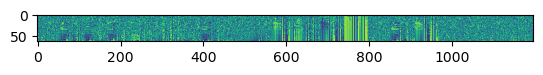

In [58]:
resize = tf.image.resize(img, (63,1197))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [53]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 22ms/step


In [54]:
yhat


array([[0.36143044, 0.2608911 , 0.04566405, 0.33201438]], dtype=float32)

In [55]:
if np.argmax(yhat) == 0: 
    print(f'Predicted class is GNAW')
elif np.argmax(yhat) == 1:
    print(f'Predicted class is KNEW')
elif np.argmax(yhat) == 2:
    print(f'Predicted class is PAT')
elif np.argmax(yhat) == 3:
    print(f'Predicted class is POT')
else:
    print(f'Error')


    


Predicted class is GNAW
